In [484]:
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
import photutils
import math

from Tutorial_functions import *
from mag_zero_est import *
from JG_Streaktools import *
from interface_setup import *
from plate_solve import *
from effective_psf import *
from beacon import *
from haversine import haversine, Unit
from IPython.display import Markdown
from scipy.optimize import minimize_scalar

# Calibration using Stationary Light Source Images

StreakTools is not built to handle point like sources, especially using the MCMC component. Therefore, this analysis is based on comparing raw counts from pill photometry within Streak Tools with that which would be expected given CCD specifications and geometry during an exposure.

## Image 1

![Photopic luminosity curve](Image_1.png)

**Distance 1  62.3 meters**

Telescope

* lat: 45.452961
* lon: -73.794476
* alt: 30m
* accuracy: 4m

Source

* lat: 45.452401
* lon: -73.794680
* alt: 30m
* accuracy: 4m

The first method of probing the raw counts from the source was to use an external stationary photometry software *AstroImageJ*. Within this program we were able to stack the lights with the dark exposures, but also get a rough estimate for the raw counts from our source. This value was used mostly as a sanity check, therefore uncertainties are not attached.

$$F_{AIJ} = 9.526 \times 10^5 counts \approx 10^6 counts$$ 

Next the use of pill photometry in Streak Tools was used to get an independent estimate for the raw counts.

In [494]:
file_name_image = 'Distance1_BS.fits'
file_path = "./"

bkg_scale = get_bkg_scale(file_path, file_name_image)

sim, hd, bkg_med, bkg_noise_map = sim_setup(file_path, file_name_image, 
                                        bkg_scale, corr = False, 
                                        bkg_sub=True, verbose=False)

In [495]:
sim.exp_t = 1 #1s exposure
sim.pixscale = .035 #Depends on Focal Length

In [496]:
r1 = real_streak(sim)

dimensions: 289 x 140


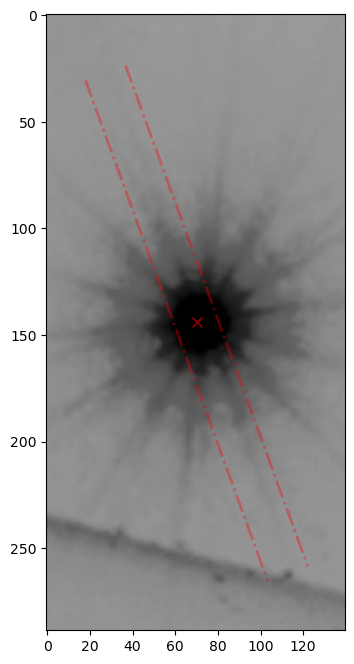

In [497]:
r1.x1 = 1167
r1.y1 = 1980
r1.L = 250
r1.theta = np.deg2rad(70)
r1.IS_rad = 300

r1.pilot()

289.0 140.0
Section created (called .sect())


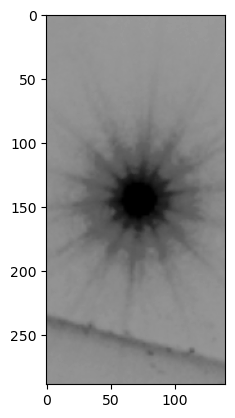

In [498]:
sim.section(r1)

NADIR angle: 41.43 degrees
Computed magnitude: 13.8258
39727 points in pill aperture
Total Flux: 1309906 +- 1537
Calculated Magnitude Zeropoint: 29.1189 +- 0.0013
True Zeropoint: 28.8880


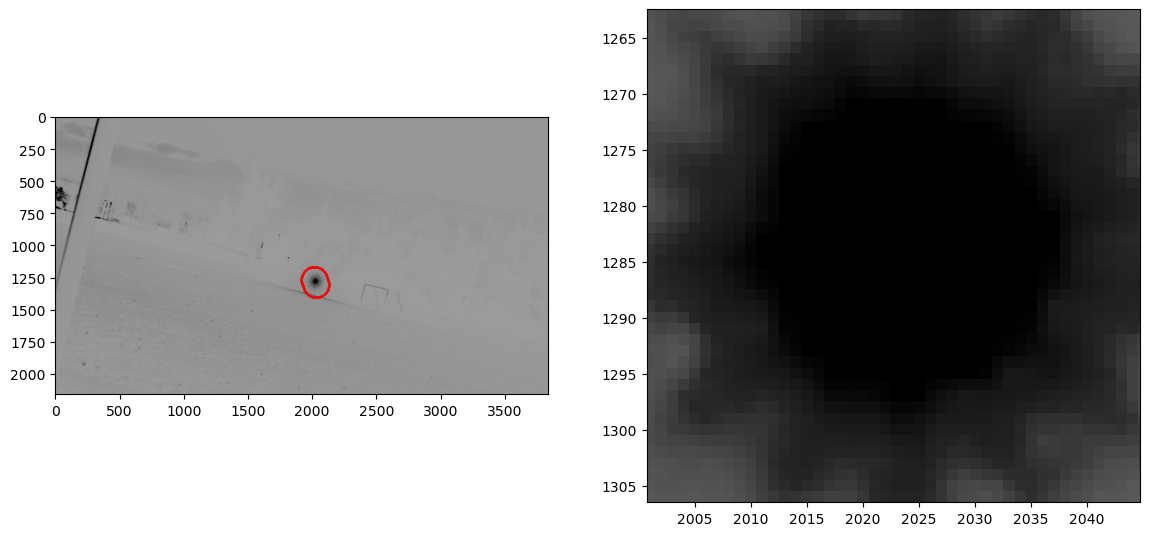

In [499]:
r1.compute_magnitude(visout = True)
sim.simpill(r1.cheatx,r1.cheaty,27*sim.fwhm,40,np.deg2rad(70),r1)

From our pill photometry we get a value which is promising in comparison to what was found using *AstroImageJ*.

$$F_{pill} = (1.309 \times 10^6 \pm 1537)counts $$

Now to calculate the measured counts of the observer we must first remind ourselves of the following values specific to the ZWO ASI585MC camera used and our light source (Note some of these values are rough and require fine tuning):
    
* **Gain:**  
  $0.8 \pm 0.1$ e$^-$/ADU at Gain = 300  

* **Peak Luminous Flux:**  
  $38\ \text{lumens} \pm 5$  
  (very rough, needs refining)

* **Light Source Wavelength:**  
  $625\ \text{nm} \pm 5\ \text{nm}$

* **Exposure Time:**  
  $1\ \text{s}$

* **Pixel Area $A_{\text{pix}}$:**  
  $(2.9\times10^{-6}\ \text{m})^2 \;=\; 8.41\times10^{-12}\ \text{m}^2$

Lumens measure brightness weighted by the human eye, not actual optical power, so we can’t use them directly in a physical camera-flux model. The CIE photopic function 
$V(\lambda)$ converts lumens into true radiant power at the LED’s wavelength, which is necessary to compute the real photon flux reaching the detector.

In [509]:
def V_lambda(lam_nm, lam_unc):
    """
    Returns (V, uncertainty) using linear interpolation
    and wavelength uncertainty lam_unc (in nm).
    """

    #sorted wavelength (nm) and V(lambda) table
    wv = np.array([600, 620, 630, 640, 650, 660, 670, 700])
    v  = np.array([0.631,0.381,0.265,0.175,0.107,0.061,0.032,0.004])

    #linear interpolation for central wavelengths
    V0 = np.interp(lam_nm, wv, v)

    #linar interpolation for wavelength bounds
    V_low  = np.interp(lam_nm - lam_unc, wv, v)
    V_high = np.interp(lam_nm + lam_unc, wv, v)

    #worst case deviation
    dV = max(abs(V0 - V_low), abs(V_high - V0))

    return V0, dV

The following function converts the LED’s luminous output in lumens into radiant intensity, which is needed for physical flux calculations.

In [511]:
def lumens_to_Irad(lumens, lumens_unc, lam_nm, lam_unc):
    """
    Convert luminous flux (lumens) to radiant intensity (W/sr)
    with wavelength and lumen uncertainties included.
    
    Uses:
        Radiant flux (Phi_rad) = lumens / (683 * V(lambda))
        Radiant intensity (I_rad) = Phi_rad / (4 * pi)
    """

    V0, dV = V_lambda(lam_nm, lam_unc) 

    #central radiant flux
    Phi_rad = lumens / (683 * V0)

    #error propagation
    rel_unc_lumens = lumens_unc / lumens
    rel_unc_V      = dV / V0

    Phi_unc = Phi_rad * np.sqrt(rel_unc_lumens**2 + rel_unc_V**2)

    #convert to radiant intensity (Assume isotropic!!)
    I_rad = Phi_rad / (4*np.pi)
    I_unc = Phi_unc / (4*np.pi)

    return I_rad, I_unc

Now need a function which calculates how much light from the LED actually reaches the observer, using the LED’s brightness, the distance, and the viewing angle.

In [513]:
def irradiance_at_distance(Irad, dIrad, dist, d_dist, theta, d_theta):
    """
    Computes irradiance F and its uncertainty dF at a distance
    from a source with radiant intensty Irad.

    Inputs:
      Irad = radiant intensity (W/sr)
      dIrad = uncertainty in radiant intensity (W/sr)
      dist = distance to observer (m)
      d_dist = distance uncertainty (m)
      theta = angle between source axis and observer (radians)
      d_theta = uncertainty in angle (radians)

    Returns:
      (F, dF) : irradiance and its propagated uncertainty
    """

    #central irradince value
    F = Irad * np.cos(theta) / dist**2

    #partial derivatives for uncertainty propagation
    dF_dI     = np.cos(theta) / dist**2
    dF_ddist  = -2 * Irad * np.cos(theta) / dist**3
    dF_dtheta = -Irad * np.sin(theta) / dist**2

    #total uncertainty (QUAD sum)
    dF = np.sqrt(
        (dF_dI     * dIrad)**2 +
        (dF_ddist  * d_dist)**2 +
        (dF_dtheta * d_theta)**2
    )

    return F, dF

In [514]:
def detected_irradiance(F, dF, S0, dS0):
    """
    Computes the detected irradiance after system throughput S0
    and propagates uncertainties in both F and S0.

    Inputs:
        F  = irradiance at the observer
        dF = uncertainty in that irradiance
        S0 = system throughput (fraction of flux detected)
        dS0 = uncertainty in system throughput

    Returns:
        (F_det, dF_det) - detected irradiance and its uncertainty
    """

    # central detected irradiance
    F_det = F * S0

    # relative uncertainties
    rel_F  = dF  / F
    rel_S0 = dS0 / S0

    # total uncertainty
    dF_det = F_det * np.sqrt(rel_F**2 + rel_S0**2)

    return F_det, dF_det

Now need a function to convert the detected irradiance into ADU by computing how many photons hit a pixel, turning those photons into electrons, and then dividing by the camera gain.

In [516]:
def ADU_per_pixel(Fdet, dFdet, lam_nm, dlam_nm, exp_time, gain_e_per_ADU, A_pix):
    """
    Computes ADU per pixel and uncertainty.

    Inputs:
        Fdet = detected irradiance at the sensor (W/m^2)
        dFdet = uncertainty in detected irradiance
        lam_nm = wavelength in nm
        dlam_nm = wavelength uncertainty in nm
        exp_time = exposure time (s)
        gain_e_per_ADU = electrons per ADU (cam gain)
        A_pix = pixel area (m^2) (given on CCD data sheet)

    Returns:
        (ADU, dADU)
    """

    #convert wavelength to m
    lam = lam_nm * 1e-9
    dlam = dlam_nm * 1e-9

    E_ph = h*c / lam

    #uncertainty handling
    dE_dlam = -h*c / lam**2
    dE_ph = abs(dE_dlam) * dlam

    #optical power on a single pixle
    P_pix = Fdet * A_pix
    dP_pix = dFdet * A_pix

    #photons
    N_ph = (P_pix * exp_time) / E_ph

    #uncertainty in photons
    dN_ph = N_ph * ( (dP_pix / P_pix)**2 + (dE_ph / E_ph)**2 )**0.5

    #Losses accounted for in S0
    N_e = N_ph
    dN_e = dN_ph 

    #ADU convs
    ADU = N_e / gain_e_per_ADU
    dADU = dN_e / gain_e_per_ADU

    return ADU, dADU

The most important step in this process that was previously forgotten is to times the ADU per pixel by the actual number of pixels used in the aperature!

In [518]:
def total_ADU(ADU_pixel, dADU_pixel, Npix):
    """
    Computes total ADU in an aperture and its uncertainty.

    Inputs:
        ADU_pixel = ADU per pixel
        dADU_pixel = uncertainty in ADU per pixel
        Npix = number of pixels in the aperture (can get from Streak Tools after performing MCMC or pill)

    Returns:
        (Total_ADU, dTotal_ADU)
    """

    Total_ADU = ADU_pixel * Npix
    dTotal_ADU = dADU_pixel * Npix

    return Total_ADU, dTotal_ADU

Wrapping everything into one function:

In [520]:
def predict_total_ADU(lumens, d_lumens,dist, d_dist, exp_time, lam_nm, d_lam_nm,
                      S0, d_S0,
                      gain_e_per_ADU,
                      Npix,
                      A_pix):

    #luminous flux to rad intensity
    Irad, dIrad = lumens_to_Irad(lumens, d_lumens, lam_nm, d_lam_nm)

    #rad intensity to irradiance @ observer
    F, dF = irradiance_at_distance(Irad, dIrad, dist, d_dist, theta=0, d_theta=0)

    #irradiance to detected irradiance (system throughpit)
    Fdet, dFdet = detected_irradiance(F, dF, S0, d_S0)

    #detected irradiance to ADU per pixel
    ADU_pix, dADU_pix = ADU_per_pixel(Fdet, dFdet,
                                      lam_nm, d_lam_nm,
                                      exp_time,
                                      gain_e_per_ADU,
                                      A_pix)

    #ADU per pixel to total ADU in aperture
    Total_ADU, dTotal_ADU = total_ADU(ADU_pix, dADU_pix, Npix)

    return Total_ADU, dTotal_ADU

Now that weve done some heavy lifting, lets run this for our first image and see what we get.

In [558]:
lumens = 38
d_lumens = 5

dist = 62.3
d_dist = 4

exp_time = 1

lam_nm = 622.5
d_lam_nm = 5

S0 = .31     #This number can be optimized so that it best fits all three of our images. It is innately            #difficult 
d_S0 = .02   #a difficult value to calculate due to CCD spec uncertanties.

gain_e_per_ADU = .8 #Rough estimate given from data sheet of CCD

Npix = 39727
A_pix = (2.9e-6)**2 

h = 6.62607015e-34
c = 2.99792458e8         

In [523]:
predict_total_ADU(lumens, d_lumens,dist, d_dist, exp_time, lam_nm, d_lam_nm,
                      S0, d_S0,
                      gain_e_per_ADU,
                      Npix,
                      A_pix)


(1314771.7637742744, 341148.71165310801)

**Measured Total ADU at Observer (d1):**

$$
F_{\text{meas}} = (1.31 \times 10^6 \;\pm\; 3.41 \times 10^5)\ \text{counts}
$$

**Streak Tools Pill Photometry**: 

$$
F_{pill} = (1.309 \times 10^6 \pm 1537)\ \text{counts} 
$$

can repeat the same process for second and third images.

## Image 2

![Photopic luminosity curve](Image_2_updated.png)

In [529]:
dist = 170.1
Npix = 8438

predict_total_ADU(lumens, d_lumens,dist, d_dist, exp_time, lam_nm, d_lam_nm,
                      S0, d_S0,
                      gain_e_per_ADU,
                      Npix,
                      A_pix)

(37460.328827663921, 8628.0151894782957)

**Measured Total ADU at Observer (d2):**

$$
F_{\text{meas}} = (3.75 \times 10^5 \;\pm\; 8628)\ \text{counts}
$$

**Streak Tools Pill Photometry**: 

$$
F_{pill} = (3.02 \times 10^5 \pm 923)\ \text{counts} 
$$

## Image 3

![Photopic luminosity curve](Image_3.png)

In [533]:
dist = 219
Npix = 4188

predict_total_ADU(lumens, d_lumens,dist, d_dist, exp_time, lam_nm, d_lam_nm,
                      S0, d_S0,
                      gain_e_per_ADU,
                      Npix,
                      A_pix)

(11216.545820438034, 2561.9843486547052)

**Measured Total ADU at Observer (d3):**

$$
F_{\text{meas}} = (1.12 \times 10^5 \;\pm\; 2561)\ \text{counts}
$$

**Streak Tools Pill Photometry**: 

$$
F_{pill} = (1.38 \times 10^5 \pm 388)\ \text{counts} 
$$

We can use the photometry results from all distances to find the $S_0$ value that makes our model match the measured ADU as closely as possible. By fitting one $S_0$ to all images at once, we get the best estimate of the system’s true throughput.

In [536]:
ADU_meas = [1309906,301942,138851] #From Streak Tools Pill
distances = [62.3, 170.1, 219.0]
Npix_list = [39727, 8438, 4188]

In [537]:
def S0_error(S0, lumens, exp_time, lam_nm, gain, A_pix, ADU_meas, distances, Npix_list):
    errors = []
    
    for ADU_obs, dist, Npix in zip(ADU_meas, distances, Npix_list):
        
        ADU_pred, _ = predict_total_ADU(
            lumens, 0,
            dist, 0,
            exp_time,
            lam_nm, 0,
            S0, 0,
            gain,
            Npix,
            A_pix
        )
        
        errors.append( (ADU_pred - ADU_obs)**2 )
    
    return sum(errors)

In [538]:
def fit_S0(lumens, exp_time, lam_nm, gain, A_pix, ADU_meas, distances, Npix_list):

    result = minimize_scalar(
        S0_error,
        bounds=(0, 1),
        method='bounded',
        args=(lumens, exp_time, lam_nm, gain, A_pix, ADU_meas, distances, Npix_list)
    )

    return result.x

In [539]:
S0_best = fit_S0(
    lumens,
    exp_time,
    lam_nm,
    gain_e_per_ADU,
    A_pix,
    ADU_meas,
    distances,
    Npix_list
)

print("Best fit S0 =", S0_best)

Best fit S0 = 0.310885449548
